In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import os
import pickle
from scipy.stats import pearsonr as corr
from tqdm import tqdm

from torchvision.models import resnet50, ResNet50_Weights, AlexNet_Weights
from torchvision.io import read_image

import torch
import sys
sys.path.append('/home/cool_klindt/PerceptualSimilarity')
import lpips

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.metrics import RocCurveDisplay

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [2]:
df = pd.read_csv('human_responses/responses_main.csv')
print('unfiltered', len(df))
df = df[df['catch_trial'] == False]
df = df[df['is_demo'] == False]
print('filtered', len(df))
df

unfiltered 69330
filtered 52920


,rt,button_pressed,switched_queries,confidence,choice,correct,min_query,max_query,min_references,max_references,...,row_variability_details,instruction_time_details,instruction_time_details_extracted,total_response_time_details_extracted,row_variability_details_details_upper_extracted,row_variability_details_details_lower_extracted,catch_trials_details_ratio_extracted,catch_trials_details_correctly_answered_extracted,demo_trials_details_extracted,multi_participation
465,2616.0,2,True,3,b,True,anonymized,anonymized,anonymized,anonymized,...,"{'n_upper_row': 28, 'n_lower_row': 17}",{'total_time': 95.379},95.379,390.716,28,17,1.0,"[True, True, True, True, True]",1,False
466,6885.0,4,False,2,b,True,anonymized,anonymized,anonymized,anonymized,...,"{'n_upper_row': 28, 'n_lower_row': 17}",{'total_time': 95.379},95.379,390.716,28,17,1.0,"[True, True, True, True, True]",1,False
467,2941.0,5,False,3,b,True,anonymized,anonymized,anonymized,anonymized,...,"{'n_upper_row': 28, 'n_lower_row': 17}",{'total_time': 95.379},95.379,390.716,28,17,1.0,"[True, True, True, True, True]",1,False
468,2624.0,5,False,3,b,True,anonymized,anonymized,anonymized,anonymized,...,"{'n_upper_row': 28, 'n_lower_row': 17}",{'total_time': 95.379},95.379,390.716,28,17,1.0,"[True, True, True, True, True]",1,False
469,5869.0,3,False,1,b,True,anonymized,anonymized,anonymized,anonymized,...,"{'n_upper_row': 28, 'n_lower_row': 17}",{'total_time': 95.379},95.379,390.716,28,17,1.0,"[True, True, True, True, True]",1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69324,3981.0,0,False,1,a,False,anonymized,anonymized,anonymized,anonymized,...,"{'n_upper_row': 21, 'n_lower_row': 24}",{'total_time': 126.789},126.789,628.439,21,24,0.8,"[True, False, True, True, True]",2,False
69325,4451.0,4,True,2,a,False,anonymized,anonymized,anonymized,anonymized,...,"{'n_upper_row': 21, 'n_lower_row': 24}",{'total_time': 126.789},126.789,628.439,21,24,0.8,"[True, False, True, True, True]",2,False
69327,19153.0,0,False,1,a,False,anonymized,anonymized,anonymized,anonymized,...,"{'n_upper_row': 21, 'n_lower_row': 24}",{'total_time': 126.789},126.789,628.439,21,24,0.8,"[True, False, True, True, True]",2,False
69328,3810.0,0,False,1,a,False,anonymized,anonymized,anonymized,anonymized,...,"{'n_upper_row': 21, 'n_lower_row': 24}",{'total_time': 126.789},126.789,628.439,21,24,0.8,"[True, False, True, True, True]",2,False


In [3]:
ind = 12387
df[ind:ind+1].to_dict()

{'rt': {16276: 5954.0},
 'button_pressed': {16276: 2},
 'switched_queries': {16276: True},
 'confidence': {16276: 3},
 'choice': {16276: 'b'},
 'correct': {16276: True},
 'min_query': {16276: 'anonymized'},
 'max_query': {16276: 'anonymized'},
 'min_references': {16276: 'anonymized'},
 'max_references': {16276: 'anonymized'},
 'catch_trial': {16276: False},
 'is_demo': {16276: False},
 'trial_type': {16276: '2afc-image-confidence-response'},
 'trial_index': {16276: 41},
 'time_elapsed': {16276: 343544},
 'internal_node_id': {16276: '0.0-4.0-0.31'},
 'response_index': {16276: 0},
 'participant_id': {16276: 'anonymized'},
 'corrected_trial_index': {16276: 31},
 'task_id': {16276: 'resnet50_natural-61'},
 'task_number': {16276: 61},
 'batch': {16276: 8.0},
 'channel': {16276: 130.0},
 'layer': {16276: 'layer3_4_conv1'},
 'mode': {16276: 'natural'},
 'model': {16276: 'resnet50'},
 'passed_checks': {16276: True},
 'demo_trials_result': {16276: True},
 'catch_trials_result': {16276: True},
 

In [4]:
filename = 'image_data/imagenet_exemplars_file_map.json'

with open(filename) as json_file:
    mapping = json.load(json_file)

list(mapping.keys())

['googlenet',
 'densenet_201',
 'wide_resnet50',
 'googlenet_hard85',
 'clip-vit_b32',
 'in1k-vit_b32',
 'convnext_b',
 'resnet50',
 'resnet50-l2',
 'resnet50_hard85',
 'resnet50_hard95',
 'clip-resnet50',
 'clip-resnet50_hard85',
 'clip-resnet50_hard95']

In [5]:
df[df['model'] == 'resnet50']['task_id'].unique()

array(['resnet50_natural-1', 'resnet50_natural-10', 'resnet50_natural-11',
       'resnet50_natural-12', 'resnet50_natural-13',
       'resnet50_natural-14', 'resnet50_natural-15',
       'resnet50_natural-16', 'resnet50_natural-17',
       'resnet50_natural-18', 'resnet50_natural-19', 'resnet50_natural-2',
       'resnet50_natural-20', 'resnet50_natural-21',
       'resnet50_natural-22', 'resnet50_natural-23',
       'resnet50_natural-24', 'resnet50_natural-25',
       'resnet50_natural-26', 'resnet50_natural-27',
       'resnet50_natural-28', 'resnet50_natural-29', 'resnet50_natural-3',
       'resnet50_natural-30', 'resnet50_natural-31',
       'resnet50_natural-32', 'resnet50_natural-33',
       'resnet50_natural-34', 'resnet50_natural-35',
       'resnet50_natural-36', 'resnet50_natural-37',
       'resnet50_natural-38', 'resnet50_natural-39', 'resnet50_natural-4',
       'resnet50_natural-40', 'resnet50_natural-41',
       'resnet50_natural-42', 'resnet50_natural-43',
       'res

In [6]:
df_resnet50 = df[df['model'] == 'resnet50']
print('resnet50', len(df_resnet50))
df_resnet50 = df_resnet50[df_resnet50['task_id'].str.contains('natural')]
print('natural', len(df_resnet50))
df_resnet50 = df_resnet50.reset_index()
print('Accuracy:', df_resnet50['correct'].mean())
df_resnet50

resnet50 7560
natural 2520
Accuracy: 0.8317460317460318


,index,rt,button_pressed,switched_queries,confidence,choice,correct,min_query,max_query,min_references,...,row_variability_details,instruction_time_details,instruction_time_details_extracted,total_response_time_details_extracted,row_variability_details_details_upper_extracted,row_variability_details_details_lower_extracted,catch_trials_details_ratio_extracted,catch_trials_details_correctly_answered_extracted,demo_trials_details_extracted,multi_participation
0,13680,3898.8,5,False,3,b,True,anonymized,anonymized,anonymized,...,"{'n_upper_row': 19, 'n_lower_row': 26}",{'total_time': 92.697},92.697,1045.662,19,26,0.8,"[True, True, True, True, False]",1,False
1,13681,6682.4,4,False,2,b,True,anonymized,anonymized,anonymized,...,"{'n_upper_row': 19, 'n_lower_row': 26}",{'total_time': 92.697},92.697,1045.662,19,26,0.8,"[True, True, True, True, False]",1,False
2,13682,21337.8,3,True,1,a,False,anonymized,anonymized,anonymized,...,"{'n_upper_row': 19, 'n_lower_row': 26}",{'total_time': 92.697},92.697,1045.662,19,26,0.8,"[True, True, True, True, False]",1,False
3,13683,6130.9,5,False,3,b,True,anonymized,anonymized,anonymized,...,"{'n_upper_row': 19, 'n_lower_row': 26}",{'total_time': 92.697},92.697,1045.662,19,26,0.8,"[True, True, True, True, False]",1,False
4,13684,26512.5,5,True,3,a,False,anonymized,anonymized,anonymized,...,"{'n_upper_row': 19, 'n_lower_row': 26}",{'total_time': 92.697},92.697,1045.662,19,26,0.8,"[True, True, True, True, False]",1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2515,16510,3364.8,5,False,3,b,True,anonymized,anonymized,anonymized,...,"{'n_upper_row': 28, 'n_lower_row': 17}",{'total_time': 226.69},226.690,706.135,28,17,1.0,"[True, True, True, True, True]",1,False
2516,16511,2397.1,5,False,3,b,True,anonymized,anonymized,anonymized,...,"{'n_upper_row': 28, 'n_lower_row': 17}",{'total_time': 226.69},226.690,706.135,28,17,1.0,"[True, True, True, True, True]",1,False
2517,16512,2549.0,5,False,3,b,True,anonymized,anonymized,anonymized,...,"{'n_upper_row': 28, 'n_lower_row': 17}",{'total_time': 226.69},226.690,706.135,28,17,1.0,"[True, True, True, True, True]",1,False
2518,16513,5620.4,5,False,3,b,True,anonymized,anonymized,anonymized,...,"{'n_upper_row': 28, 'n_lower_row': 17}",{'total_time': 226.69},226.690,706.135,28,17,1.0,"[True, True, True, True, True]",1,False


In [7]:
# load images
ind = 42
trial_dic = df_resnet50[ind:ind+1].to_dict()
model = trial_dic['model'][ind]
layer = '%s/channel_%s' % (
    trial_dic['layer'][ind], int(trial_dic['channel'][ind])
)
batch = 'batch_%i' % trial_dic['batch'][ind]
print(model, layer, batch)
mapping[model][layer][batch].keys()

resnet50 layer1_0_conv2/channel_36 batch_4


dict_keys(['min_7.png', 'max_6.png', 'max_4.png', 'max_8.png', 'max_1.png', 'min_3.png', 'min_0.png', 'min_5.png', 'max_2.png', 'max_9.png', 'min_2.png', 'min_6.png', 'min_1.png', 'min_4.png', 'max_3.png', 'max_5.png', 'max_7.png', 'min_8.png', 'max_0.png', 'min_9.png'])

### Roland: 0-8 are reference and 9 is always the query

In [26]:
mapping[model][layer][batch]['max_9.png']

'n01739381/n01739381_4994.JPEG'

In [27]:
imagenet_dir = '/home/datasets/ImageNet/ILSVRC/Data/CLS-LOC/train/'

filename = os.path.join(imagenet_dir, mapping[model][layer][batch]['max_9.png'])
print(filename)

/home/datasets/ImageNet/ILSVRC/Data/CLS-LOC/train/n01739381/n01739381_4994.JPEG


In [28]:
# Initialize the Weight Transforms
# weights = ResNet50_Weights.DEFAULT
weights = AlexNet_Weights.DEFAULT  # for lpips
preprocess = weights.transforms()

def load_image(filename):
    img = read_image(filename)
    if img.shape[0] == 1:
        img = img.repeat((3, 1, 1))
    return preprocess(img)

img = load_image(filename)
print(type(img), img.shape, img.min(), img.max(), img.dtype)

<class 'torch.Tensor'> torch.Size([3, 224, 224]) tensor(-2.1179) tensor(2.4111) torch.float32


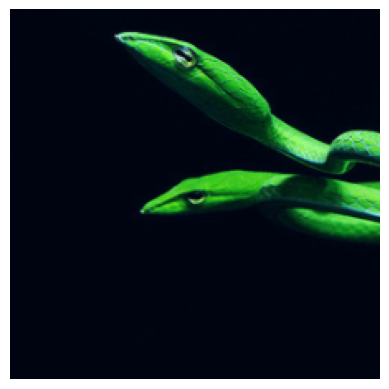

In [29]:
def imshow(img):
    x = img.numpy()
    x = x - np.min(x)
    x = x / np.max(x)
    plt.imshow(np.transpose(x, (1, 2, 0)))
    plt.axis('off')

imshow(img)

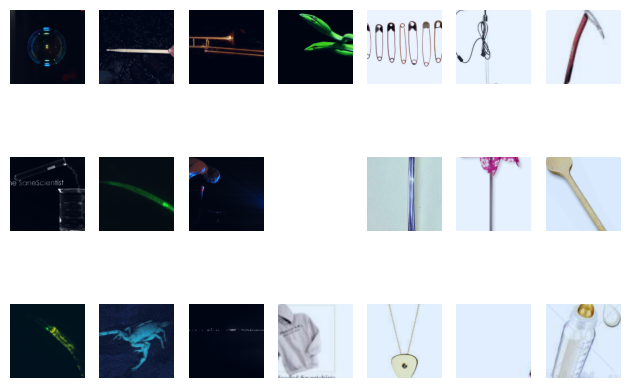

In [30]:
img_top = []
img_bottom = []

indices = [1, 2, 3, 8, 9, 10, 15, 16, 17]

for i in range(10):
    filename = os.path.join(
        imagenet_dir, 
        mapping[model][layer][batch]['max_%s.png' % i]
    )
    img = load_image(filename)
    img_top.append(img)
    if i == 9:
        plt.subplot(3, 7, 4)
        imshow(img)
    else:
        plt.subplot(3, 7, indices[i])
        imshow(img)
    filename = os.path.join(
        imagenet_dir, 
        mapping[model][layer][batch]['min_%s.png' % i]
    )
    img = load_image(filename)
    img_bottom.append(img)
    if i == 9:
        plt.subplot(3, 7, 18)
        imshow(img)
    else:
        plt.subplot(3, 7, indices[i] + 4)
        imshow(img)

plt.tight_layout()
plt.show()

img_top = torch.stack(img_top, 0).to(device)
img_bottom = torch.stack(img_bottom, 0).to(device)

In [41]:
# lpips
loss_fn_alex = lpips.LPIPS(net='alex').to(device)

def perceptual_similarity(a, b):
    _, ret = loss_fn_alex(a, b, normalize=False, retPerLayer=True)
    return -torch.stack(ret, dim=-1).detach().cpu().numpy()

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/cool_klindt/PerceptualSimilarity/lpips/weights/v0.1/alex.pth


In [45]:
# lpips
pool_fun = np.array
logits = np.zeros((2, 2, 9, 1, 5))
# choose top
logits[0, 0] = pool_fun(perceptual_similarity(img_top[:-1], img_top[-1:])) # evidence from top
logits[0, 1] = pool_fun(perceptual_similarity(img_bottom[:-1], img_bottom[-1:])) # evidence from bottom
# choose bottom
logits[1, 0] = pool_fun(perceptual_similarity(img_top[:-1], img_bottom[-1:])) # evidence from top
logits[1, 1] = pool_fun(perceptual_similarity(img_bottom[:-1], img_top[-1:])) # evidence from bottom

In [46]:
# layer average
print('choose top', logits[0].sum())
print('choose bottom', logits[1].sum())

# per layer
for i in range(5):
    print(i, 'choose top', logits[0, ..., i].sum(), 'choose bottom', logits[1, ..., i].sum())

choose top -9.520373628474772
choose bottom -17.965351276099682
0 choose top -0.36580165196210146 choose bottom -3.2820006161928177
1 choose top -1.9393149688839912 choose bottom -3.6427538096904755
2 choose top -2.5881265476346016 choose bottom -4.17070497572422
3 choose top -2.967470809817314 choose bottom -4.326785609126091
4 choose top -1.6596596501767635 choose bottom -2.5431062653660774


In [47]:
trial_dic['correct'][ind]

True

In [48]:
np.random.seed(42)
ind = np.random.randint(len(df_resnet50))

trial_dic = df_resnet50[ind:ind+1].to_dict()
model = trial_dic['model'][ind]
layer = '%s/channel_%s' % (
    trial_dic['layer'][ind], int(trial_dic['channel'][ind])
)
batch = 'batch_%i' % trial_dic['batch'][ind]
print(ind, model, layer, batch)

img_top, img_bottom = [], []

for i in range(10):
    filename = os.path.join(
        imagenet_dir, 
        mapping[model][layer][batch]['max_%s.png' % i]
    )
    img = load_image(filename)
    img_top.append(img)
    filename = os.path.join(
        imagenet_dir, 
        mapping[model][layer][batch]['min_%s.png' % i]
    )
    img = load_image(filename)
    img_bottom.append(img)


img_top = torch.stack(img_top, 0).to(device)
img_bottom = torch.stack(img_bottom, 0).to(device)

# lpips
pool_fun = np.array
logits = np.zeros((2, 2, 9, 1, 5))
# choose top
logits[0, 0] = pool_fun(perceptual_similarity(img_top[:-1], img_top[-1:])) # evidence from top
logits[0, 1] = pool_fun(perceptual_similarity(img_bottom[:-1], img_bottom[-1:])) # evidence from bottom
# choose bottom
logits[1, 0] = pool_fun(perceptual_similarity(img_top[:-1], img_bottom[-1:])) # evidence from top
logits[1, 1] = pool_fun(perceptual_similarity(img_bottom[:-1], img_top[-1:])) # evidence from bottom

print('trial', trial_dic['correct'][ind], 'in silico', correct)
# layer average
print('choose top', logits[0].sum())
print('choose bottom', logits[1].sum())
# per layer
for i in range(5):
    print(i, 'choose top', logits[0, ..., i].sum(), 'choose bottom', logits[1, ..., i].sum())

860 resnet50 layer3_5_conv3/channel_763 batch_3
trial True in silico True
choose top -14.809414774179459
choose bottom -18.416907839477062
0 choose top -1.5725794211030006 choose bottom -2.6901246830821037
1 choose top -4.2554015442729 choose bottom -5.377188667654991
2 choose top -3.4504340142011642 choose bottom -4.0165693163871765
3 choose top -3.316931813955307 choose bottom -3.753715679049492
4 choose top -2.214067980647087 choose bottom -2.579309493303299


In [34]:
np.random.seed(42)
indices = np.random.randint(0, len(df_resnet50), 1000)
correct_trial = []
correct_silico = []
logit_diffs = []
indices_used = []
layers = []
confidences = []
logits_all = []
for j, ind in enumerate(indices):
    try:
        trial_dic = df_resnet50[ind:ind+1].to_dict()
        model = trial_dic['model'][ind]
        layer = '%s/channel_%s' % (
            trial_dic['layer'][ind], int(trial_dic['channel'][ind])
        )
        batch = 'batch_%i' % trial_dic['batch'][ind]
        print(ind, model, layer, batch)

        img_top, img_bottom = [], []

        for i in range(10):
            filename = os.path.join(
                imagenet_dir, 
                mapping[model][layer][batch]['max_%s.png' % i]
            )
            img = load_image(filename)
            img_top.append(img)
            filename = os.path.join(
                imagenet_dir, 
                mapping[model][layer][batch]['min_%s.png' % i]
            )
            img = load_image(filename)
            img_bottom.append(img)


        img_top = torch.stack(img_top, 0).to(device)
        img_bottom = torch.stack(img_bottom, 0).to(device)

        # lpips
        logits = np.zeros((2, 2, 9))
        # choose top
        logits[0, 0] = pool_fun(perceptual_similarity(img_top[:-1], img_top[-1:])) # evidence from top
        logits[0, 1] = pool_fun(perceptual_similarity(img_bottom[:-1], img_bottom[-1:])) # evidence from bottom
        # choose bottom
        logits[1, 0] = pool_fun(perceptual_similarity(img_top[:-1], img_bottom[-1:])) # evidence from top
        logits[1, 1] = pool_fun(perceptual_similarity(img_bottom[:-1], img_top[-1:])) # evidence from bottom

        logit_diff = logits[0].mean() - logits[1].mean()
        correct_silico.append(logit_diff > 0)
        logit_diffs.append(logit_diff)

        correct_trial.append(trial_dic['correct'][ind])
        indices_used.append(ind)
        layers.append(layer)
        confidences.append(trial_dic['confidence'][ind])
        logits_all.append(logits.copy())

        if not len(indices_used) % 10:
            print(
                'n=%s\n' % len(indices_used), 
                'match so far correct_silico', corr(np.array(correct_trial), np.array(correct_silico)), 
                '\ncorr with logit diff', corr(np.array(correct_trial), np.array(logit_diffs)), 
                '\n'
            )
    except Exception as e:
        print(e)


860 resnet50 layer3_5_conv3/channel_763 batch_3
1294 resnet50 layer4_2_bn3/channel_955 batch_8
1130 resnet50 layer2_3_conv2/channel_64 batch_6
1095 resnet50 layer3_1_bn3/channel_957 batch_5
1638 resnet50 layer3_0_bn1/channel_134 batch_0
2169 resnet50 layer1_0_shortcut/channel_200 batch_7
466 resnet50 layer3_3_shortcut/channel_690 batch_0
1238 resnet50 layer3_5_conv1/channel_207 batch_7
330 resnet50 layer3_5_bn2/channel_36 batch_8
1482 resnet50 layer2_0_conv1/channel_52 batch_10
n=10
 match so far correct_silico PearsonRResult(statistic=-0.2182178902359923, pvalue=0.544737300804491) 
corr with logit diff PearsonRResult(statistic=-0.04914922455580337, pvalue=0.8927454106933932) 

2135 resnet50 layer3_2_bn1/channel_226 batch_6
130 resnet50 layer1_0_conv2/channel_36 batch_5
1685 resnet50 layer2_1_conv3/channel_378 batch_1
769 resnet50 layer3_1_bn2/channel_13 batch_2
2391 resnet50 layer1_1_bn1/channel_25 batch_9
1515 resnet50 layer3_1_conv3/channel_20 batch_10
2433 resnet50 layer2_1_conv3/c

In [35]:
correct_trial = np.array(correct_trial)
correct_silico = np.array(correct_silico_mean_mean)
confidences = np.array(confidences)

In [37]:
results = {
    'correct_trial': correct_trial,
    'correct_silico': correct_silico,
    'logit_diffs': logit_diffs,
    'indices_used': indices_used,
    'layers': layers,
    'confidences': confidences,
    'logits_all': logits_all,
}


with open('results0.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

#with open('results0.pickle', 'rb') as handle:
#    results = pickle.load(handle)

In [ ]:
for i in range(1, 5):
    layer = 'layer%s' % i
    ind = np.array([l.startswith(layer) for l in layers])
    print(
        layer, 'n=', ind.sum(), 
        'match', np.mean(correct_trial[ind] == correct_silico[ind]),
        'average confidences', np.mean(confidences[ind])
    )

layer1 n= 141 match 0.7872340425531915 average confidences 2.617021276595745
layer2 n= 216 match 0.8055555555555556 average confidences 2.5416666666666665
layer3 n= 439 match 0.826879271070615 average confidences 2.5375854214123006
layer4 n= 204 match 0.7205882352941176 average confidences 2.5588235294117645


In [ ]:
# compare to confidence
for confidence, n in zip(*np.unique(confidences, return_counts=True)):
    ind = confidences == confidence
    print(
        'confidence', confidence,
        'n', n,
        'acc', np.mean(correct_trial[ind] == correct_silico[ind])
    )
    

confidence 1 n 84 acc 0.7023809523809523
confidence 2 n 278 acc 0.7517985611510791
confidence 3 n 638 acc 0.8260188087774295


In [ ]:
for i in range(1, 5):
    layer = 'layer%s' % i
    ind = np.logical_and(
        np.array([l.startswith(layer) for l in layers]),
        confidences == 3
    )
    print(layer, 'n=', ind.sum(), 'match', np.mean(correct_trial[ind] == correct_silico[ind]))

layer1 n= 97 match 0.8144329896907216
layer2 n= 133 match 0.8721804511278195
layer3 n= 270 match 0.8518518518518519
layer4 n= 138 match 0.7391304347826086


The match is better for higher confidence and lower layers

In [ ]:


confusion_matrix(correct_trial, correct_silico)

array([[ 21, 161],
       [ 44, 774]])

In [ ]:
for i in range(1, 5):
    layer = 'layer%s' % i
    ind = np.logical_and(
        np.array([l.startswith(layer) for l in layers]),
        confidences == 3
    )
    print(
        layer, 'n=', ind.sum(), 
        'psychphysics correct', np.mean(correct_trial[ind]),
        'silico correct', np.mean(correct_silico[ind]),
    )

layer1 n= 97 psychphysics correct 0.865979381443299 silico correct 0.9484536082474226
layer2 n= 133 psychphysics correct 0.8571428571428571 silico correct 0.9699248120300752
layer3 n= 270 psychphysics correct 0.8333333333333334 silico correct 0.9666666666666667
layer4 n= 138 psychphysics correct 0.8333333333333334 silico correct 0.8188405797101449


In silico is almost always right...

In [ ]:
logits_all = np.array(logits_all)

In [ ]:
logits_all.shape, confidences.shape

((1000, 2, 2, 9), (1000,))

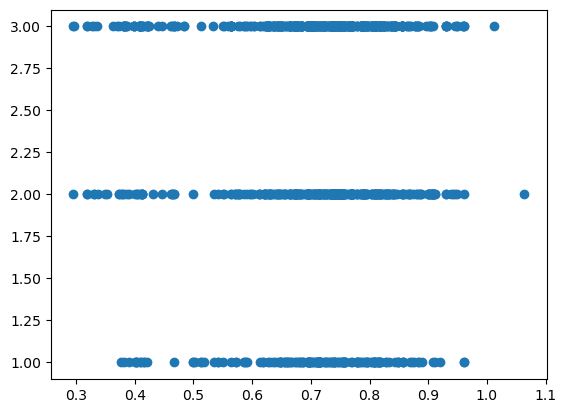

In [ ]:
plt.scatter(
    logits_all[:, 0, 0].mean(1),
    confidences
)

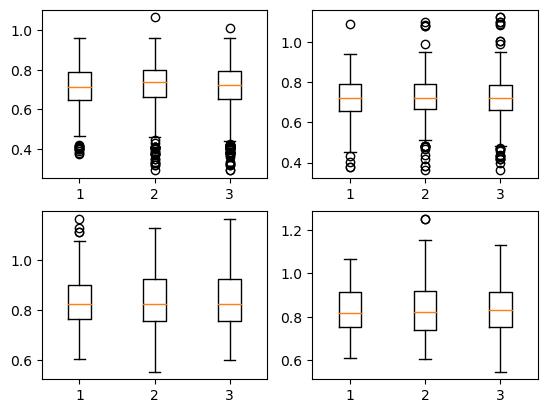

In [ ]:
for i in range(2):
    for j in range(2):
        plt.subplot(2, 2, i * 2 + j + 1)
        plt.boxplot(
            [logits_all[confidences==k, i, j].mean(1) for k in range(1, 4)],
        )
plt.show()

In [64]:


y = correct_trial.copy().flatten()
X = np.array(logits_all).copy().reshape(y.shape[0], -1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42, stratify=y)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

LR_clf = LogisticRegression(
    random_state=0, 
    class_weight='balanced'
).fit(X_train, y_train)
print(
    LR_clf,
    '\ntrain: acc=%.4f, corr=%.4f, p=%.4e' % (
        LR_clf.score(X_train, y_train), *corr(y_train, LR_clf.predict(X_train))),
    '\ntest: acc=%.4f, corr=%.4f, p=%.4e' % (
        LR_clf.score(X_test, y_test), *corr(y_test, LR_clf.predict(X_test))),
)

RF_clf = RandomForestClassifier(
    random_state=0,
    n_estimators=100,
    class_weight='balanced',
    max_depth=None
).fit(X_train, y_train)
print(
    RF_clf,
    '\ntrain: acc=%.4f, corr=%.4f, p=%.4e' % (
        RF_clf.score(X_train, y_train), *corr(y_train, RF_clf.predict(X_train))),
    '\ntest: acc=%.4f, corr=%.4f, p=%.4e' % (
        RF_clf.score(X_test, y_test), *corr(y_test, RF_clf.predict(X_test))),
)

(670, 36) (670,) (330, 36) (330,)
LogisticRegression(class_weight='balanced', random_state=0) 
train: acc=0.5015, corr=0.0556, p=1.5043e-01 
test: acc=0.5242, corr=0.1030, p=6.1697e-02
RandomForestClassifier(class_weight='balanced', random_state=0) 
train: acc=0.9567, corr=0.8635, p=8.6669e-201 
test: acc=0.8182, corr=0.2976, p=3.5677e-08


{'whiskers': [<matplotlib.lines.Line2D at 0x7fbd5c10c430>,
 'caps': [<matplotlib.lines.Line2D at 0x7fbd5c10c850>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fbd5c10c190>,
 'medians': [<matplotlib.lines.Line2D at 0x7fbd5c10cd90>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fbd5c10d030>,
 'means': []}

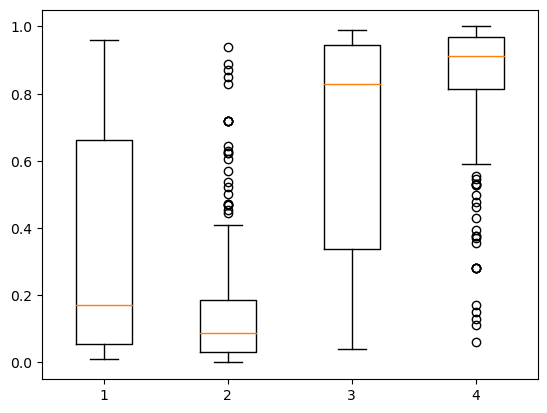

In [75]:
plt.boxplot([
    RF_clf.predict_proba(X_test)[y_test==0, 0],
    RF_clf.predict_proba(X_test)[y_test==1, 0],
    RF_clf.predict_proba(X_test)[y_test==0, 1],
    RF_clf.predict_proba(X_test)[y_test==1, 1],
    ])
plt.xticks(
    [1, 2, 3, 4],
    ['true negative', 'false positive', ]
)

In [57]:
# compute distances and similarities across all (also across lpips layers)
np.random.seed(42)
indices = np.random.randint(0, len(df_resnet50), 1000)
correct_trial = []
indices_used = []
layers = []
confidences = []
logits_all = []
for j, ind in tqdm(enumerate(indices)):
    try:
        trial_dic = df_resnet50[ind:ind+1].to_dict()
        model = trial_dic['model'][ind]
        layer = '%s/channel_%s' % (
            trial_dic['layer'][ind], int(trial_dic['channel'][ind])
        )
        batch = 'batch_%i' % trial_dic['batch'][ind]
        #print(ind, model, layer, batch)

        img_top, img_bottom = [], []

        for i in range(10):
            filename = os.path.join(
                imagenet_dir, 
                mapping[model][layer][batch]['max_%s.png' % i]
            )
            img = load_image(filename)
            img_top.append(img)
            filename = os.path.join(
                imagenet_dir, 
                mapping[model][layer][batch]['min_%s.png' % i]
            )
            img = load_image(filename)
            img_bottom.append(img)


        img_top = torch.stack(img_top, 0).to(device)
        img_bottom = torch.stack(img_bottom, 0).to(device)
        img_all = torch.cat([img_top, img_bottom], 0)
        logits = perceptual_similarity(img_all, img_all)

        correct_trial.append(trial_dic['correct'][ind])
        indices_used.append(ind)
        layers.append(layer)
        confidences.append(trial_dic['confidence'][ind])
        logits_all.append(logits.copy())
        
    except Exception as e:
        print(e)


203it [06:48,  2.01s/it]


KeyboardInterrupt: 

In [51]:
import tqdm

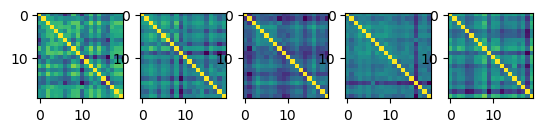

In [50]:
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(logits[:, :, i])

In [ ]:
correct_trial = np.array(correct_trial)
indices_used = np.array(indices_used)
layers = np.array(layers)
confidences = np.array(confidences)
logits_all = np.array(logits_all)

results = {
    'correct_trial': correct_trial,
    'indices_used': indices_used,
    'layers': layers,
    'confidences': confidences,
    'logits_all': logits_all,
}


with open('results1.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

#with open('results1.pickle', 'rb') as handle:
#    results = pickle.load(handle)

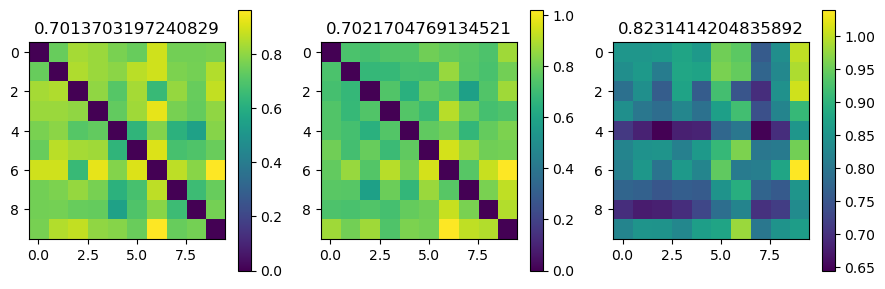

In [ ]:
plt.figure(figsize=(9, 3))
for i in range(3):
    plt.subplot(1, 3, 1 + i)
    plt.imshow(logits[i])
    plt.colorbar()
    plt.title(np.mean(logits[i]))
plt.tight_layout()

In [ ]:
logits_all.shape, correct_trial.shape

((100, 3, 10, 10), (100,))

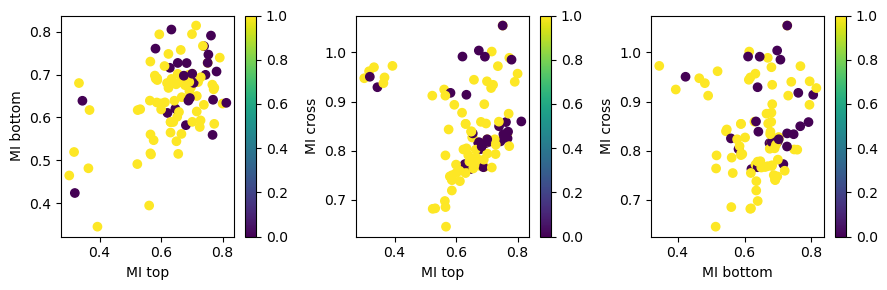

In [ ]:
plt.figure(figsize=(9, 3))
plt.subplot(1, 3, 1)
plt.scatter(
    logits_all[:, 0].mean((1, 2)),
    logits_all[:, 1].mean((1, 2)),
    c=correct_trial
)
plt.colorbar()
plt.xlabel('MI top')
plt.ylabel('MI bottom')

plt.subplot(1, 3, 2)
plt.scatter(
    logits_all[:, 0].mean((1, 2)),
    logits_all[:, 2].mean((1, 2)),
    c=correct_trial
)
plt.xlabel('MI top')
plt.ylabel('MI cross')
plt.colorbar()

plt.subplot(1, 3, 3)
plt.scatter(
    logits_all[:, 1].mean((1, 2)),
    logits_all[:, 2].mean((1, 2)),
    c=correct_trial
)
plt.xlabel('MI bottom')
plt.ylabel('MI cross')
plt.colorbar()
plt.tight_layout()

In [ ]:
from sklearn.linear_model import LogisticRegression

X = logits_all.copy().mean((2, 3))
y = correct_trial.copy().flatten()

clf = LogisticRegression(random_state=0).fit(X, y)
clf.score(X, y)

0.73

In [ ]:
for i in range(1, 5):
    layer = 'layer%s' % i
    ind = np.logical_and(
        np.array([l.startswith(layer) for l in layers]),
        confidences == 3
    )
    print(layer, 'n=', ind.sum(), 'match', clf.score(X[ind], y[ind]))

layer1 n= 6 match 0.8333333333333334
layer2 n= 9 match 0.6666666666666666
layer3 n= 22 match 0.8181818181818182
layer4 n= 10 match 0.6


# Load Results

In [285]:
with open('results_resnet50.pickle', 'rb') as handle:
    results = pickle.load(handle)
results.keys(), np.array(results['logits_all']).shape

(dict_keys(['correct_trial', 'layers', 'confidences', 'logits_all']),
 (2511, 20, 20, 5))

(array([ 241.,    0.,    0.,    0.,    0.,  687.,    0.,    0.,    0.,
        1583.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <BarContainer object of 10 artists>)

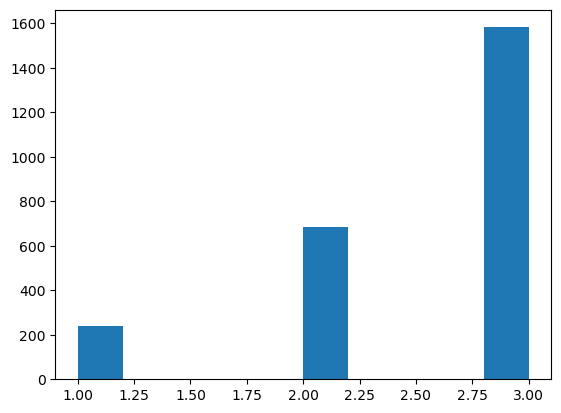

In [286]:
plt.hist(results['confidences'])

In [287]:
ind = np.array(results['confidences']) > 0
ind.sum()

2511

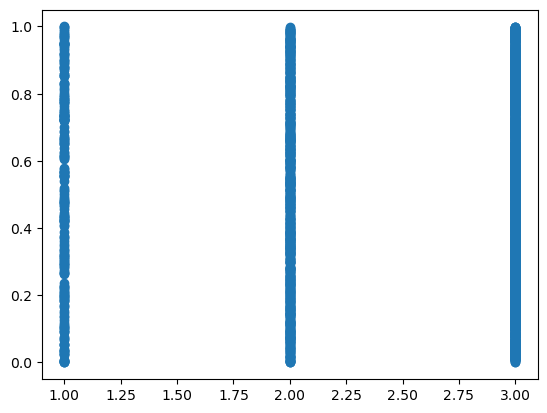

In [326]:
depth = np.argsort(results['layers'])
depth = depth / depth.max()
plt.scatter(np.array(results['confidences']), depth)

In [345]:
y = np.array(results['correct_trial']).copy().flatten()[ind]
print(np.mean(y))
X = np.array(results['logits_all']).copy()[ind]
print(X.shape)
triu_indices = np.triu_indices(20, 1)
X = X[:, triu_indices[0], triu_indices[1], :]
print(X.shape)
#X = X.mean(-1)
print(X.shape)
X = X.reshape(y.shape[0], -1)
print(X.shape)
#X = np.concatenate([X, np.array(results['confidences'])[ind, None], depth[ind, None]], 1)
print(X.shape)

indices = np.arange(X.shape[0])
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(
    X, y, indices, test_size=0.3, random_state=42, stratify=y)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

LR_clf = LogisticRegression(
    random_state=0, 
    class_weight='balanced'
).fit(X_train, y_train)
print(
    LR_clf,
    '\ntrain: acc=%.4f, corr=%.4f, p=%.4e' % (
        LR_clf.score(X_train, y_train), *corr(y_train, LR_clf.predict(X_train))),
    '\ntest: acc=%.4f, corr=%.4f, p=%.4e' % (
        LR_clf.score(X_test, y_test), *corr(y_test, LR_clf.predict(X_test))),
)

LR_clf = LogisticRegression(
    random_state=0, 
    class_weight='balanced'
).fit(X_train, y_train)
print(
    LR_clf,
    '\ntrain: acc=%.4f, corr=%.4f, p=%.4e' % (
        LR_clf.score(X_train, y_train), *corr(y_train, LR_clf.predict(X_train))),
    '\ntest: acc=%.4f, corr=%.4f, p=%.4e' % (
        LR_clf.score(X_test, y_test), *corr(y_test, LR_clf.predict(X_test))),
    '\nAUC: %.4f' % roc_auc_score(y_true=y_test, y_score=LR_clf.predict_proba(X_test)[:, 1])
)

RF_clf = RandomForestClassifier(
    random_state=0,
    n_estimators=10,
    class_weight='balanced',
    max_depth=4
).fit(X_train, y_train)
print(
    RF_clf,
    '\ntrain: acc=%.4f, corr=%.4f, p=%.4e' % (
        RF_clf.score(X_train, y_train), *corr(y_train, RF_clf.predict(X_train))),
    '\ntest: acc=%.4f, corr=%.4f, p=%.4e' % (
        RF_clf.score(X_test, y_test), *corr(y_test, RF_clf.predict(X_test))),
    '\nAUC: %.4f' % roc_auc_score(y_true=y_test, y_score=RF_clf.predict_proba(X_test)[:, 1])
)

0.8311429709279171
(2511, 20, 20, 5)
(2511, 190, 5)
(2511, 190, 5)
(2511, 950)
(2511, 950)
(1757, 950) (1757,) (754, 950) (754,)


/home/cool_klindt/anaconda3/envs/pytorch/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced', random_state=0) 
train: acc=0.7564, corr=0.4110, p=1.3587e-72 
test: acc=0.6592, corr=0.0964, p=8.0706e-03


/home/cool_klindt/anaconda3/envs/pytorch/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced', random_state=0) 
train: acc=0.7564, corr=0.4110, p=1.3587e-72 
test: acc=0.6592, corr=0.0964, p=8.0706e-03 
AUC: 0.5882
RandomForestClassifier(class_weight='balanced', max_depth=4, n_estimators=10,
                       random_state=0) 
train: acc=0.8287, corr=0.4597, p=1.4545e-92 
test: acc=0.7467, corr=0.1726, p=1.8787e-06 
AUC: 0.6433


In [331]:
RF_clf.feature_importances_

array([6.55544705e-03, 0.00000000e+00, 0.00000000e+00, 1.12610091e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 6.88604063e-03, 6.27723614e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.97904344e-03, 0.00000000e+00, 0.00000000e+00, 3.44197948e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [332]:
for n_estimators in [10, 30, 50, 100]:
    for max_depth in [1, 2, 3, 4, None]:
        RF_clf = RandomForestClassifier(
            random_state=0,
            n_estimators=n_estimators,
            class_weight='balanced',
            max_depth=max_depth
        ).fit(X_train, y_train)
        print(
            'n_estimators', n_estimators, 'max_depth', max_depth, 
            corr(y_train, RF_clf.predict(X_train))[0],
            corr(y_test, RF_clf.predict(X_test))[0],
            roc_auc_score(y_true=y_test, y_score=RF_clf.predict_proba(X_test)[:, 1])
        )

n_estimators 10 max_depth 1 0.1297443537737337 0.09410226957389288 0.5932574815707845
n_estimators 10 max_depth 2 0.238877585344237 0.2073590231486002 0.6311331298898641
n_estimators 10 max_depth 3 0.34481576074244363 0.13658538589874036 0.6313780155470996
n_estimators 10 max_depth 4 0.410365477774463 0.17811849942749086 0.6517035250976403
n_estimators 10 max_depth None 0.9020324821383474 0.18200208137546145 0.6058408368810357
n_estimators 30 max_depth 1 0.22348201041980026 0.1297817210275902 0.6122706551633199
n_estimators 30 max_depth 2 0.30379323948081016 0.13025542516655342 0.617821396727323
n_estimators 30 max_depth 3 0.4381391446343042 0.1518299241638526 0.6247284280852454
n_estimators 30 max_depth 4 0.5124708721782935 0.163283600944566 0.6361564254228986
n_estimators 30 max_depth None 0.9837567925525622 0.1661733748515104 0.6249795928618971
n_estimators 50 max_depth 1 0.26523011850384376 0.11200136775693811 0.6092692360823317
n_estimators 50 max_depth 2 0.3224312484455554 0.1604

In [347]:
ind = np.array(results['confidences']) > 0
ind.sum()

y = np.array(results['correct_trial']).copy().flatten()[ind]
X = np.array(results['logits_all']).copy()[ind]
print(X.shape, y.shape)
X = X.mean(-1)
print(X.shape)

pool_fun = np.max
log0 = 1 * pool_fun(X[:, :9, 9], 1) + 1 * pool_fun(X[:, 10:19, 19], 1)
log1 = 1 * pool_fun(X[:, :9, 19], 1) + 1 * pool_fun(X[:, 10:19, 9], 1)
log_diff = log0 - log1
print(log_diff.shape)
corr(log_diff, y), roc_auc_score(y_true=y, y_score=log_diff)

(2511, 20, 20, 5) (2511,)
(2511, 20, 20)
(2511,)


(PearsonRResult(statistic=0.10250459968252933, pvalue=2.6398227445156195e-07),
 0.592767107249731)

In [334]:
for alpha in np.linspace(0, 1, 10):
    log0 = alpha * pool_fun(X[:, :9, 9], 1) + (1 - alpha) * pool_fun(X[:, 10:19, 19], 1)
    log1 = alpha * pool_fun(X[:, :9, 19], 1) + (1 - alpha) * pool_fun(X[:, 10:19, 9], 1)
    log_diff = log0 - log1
    print(alpha, corr(log_diff, y), roc_auc_score(y_true=y, y_score=log_diff))

0.0 PearsonRResult(statistic=0.03798585114613585, pvalue=0.0570137369062771) 0.5162545994521341
0.1111111111111111 PearsonRResult(statistic=0.052044366251936036, pvalue=0.009096496391767671) 0.5285827132925296
0.2222222222222222 PearsonRResult(statistic=0.06725643862062942, pvalue=0.0007452893215865757) 0.5440253455804577
0.3333333333333333 PearsonRResult(statistic=0.0825751981054068, pvalue=3.430172256585722e-05) 0.5620242335753225
0.4444444444444444 PearsonRResult(statistic=0.09651597041581948, pvalue=1.2641377392251883e-06) 0.5833647874081239
0.5555555555555556 PearsonRResult(statistic=0.10765802669735362, pvalue=6.381510959485492e-08) 0.5994707804829538
0.6666666666666666 PearsonRResult(statistic=0.11525777007312485, pvalue=6.955787702589635e-09) 0.6044047382267586
0.7777777777777777 PearsonRResult(statistic=0.11945796653868339, pvalue=1.9185640096008902e-09) 0.6033865302727577
0.8888888888888888 PearsonRResult(statistic=0.12098467941797293, pvalue=1.1879553338996321e-09) 0.6006279

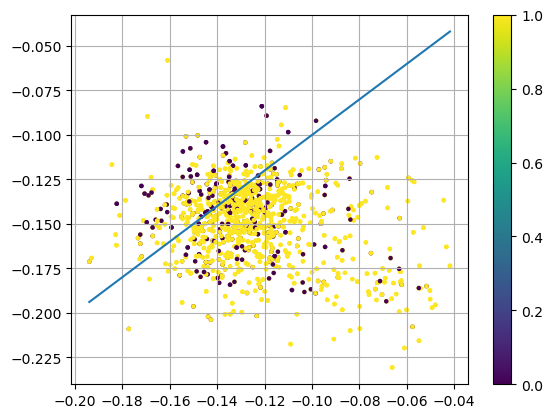

In [335]:
plt.scatter(log0, log1, c=y, s=5)
plt.plot((log0.min(), log0.max()), (log0.min(), log0.max()))
plt.grid()
plt.colorbar()

In [336]:
alpha = 1
log0 = alpha * pool_fun(X[:, :9, 9], 1) + (1 - alpha) * pool_fun(X[:, 10:19, 19], 1)
log1 = alpha * pool_fun(X[:, :9, 19], 1) + (1 - alpha) * pool_fun(X[:, 10:19, 9], 1)
log_diff = log0 - log1

m = confusion_matrix(y_true=y, y_pred=log_diff > 0, normalize='true')
print('True negative', m[0, 0])
print('True positive', m[1, 1])
print('False negative', m[1, 0])
print('False positive', m[0, 1])

True negative 0.33962264150943394
True positive 0.7910876856732152
False negative 0.20891231432678486
False positive 0.660377358490566


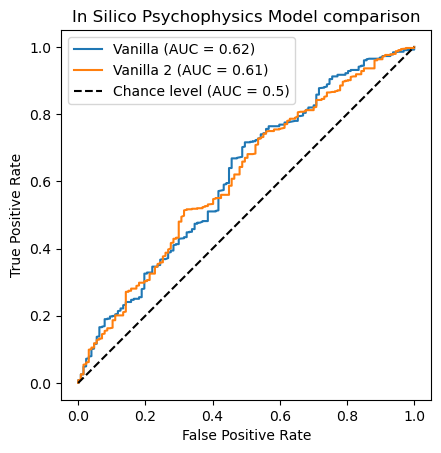

In [348]:
alpha = .66
log0 = alpha * pool_fun(X[:, :9, 9], 1) + (1 - alpha) * pool_fun(X[:, 10:19, 19], 1)
log1 = alpha * pool_fun(X[:, :9, 19], 1) + (1 - alpha) * pool_fun(X[:, 10:19, 9], 1)
log_diff = log0 - log1

#log0 = 1 * pool_fun(X[:, :9, 9], 1) + 0 * pool_fun(X[:, 10:19, 19], 1)
#log1 = 1 * pool_fun(X[:, :9, 19], 1) + 0 * pool_fun(X[:, 10:19, 9], 1)
#log_diff = log0 - log1

RocCurveDisplay.from_predictions(
    y[indices_test],
    log_diff[indices_test],
    name="Vanilla",
)

log0 = 1 * pool_fun(X[:, :9, 9], 1) + 1 * pool_fun(X[:, 10:19, 19], 1)
log1 = 1 * pool_fun(X[:, :9, 19], 1) + 1 * pool_fun(X[:, 10:19, 9], 1)
log_diff = log0 - log1

RocCurveDisplay.from_predictions(
    y[indices_test],
    log_diff[indices_test],
    name="Vanilla 2",
    plot_chance_level=True,
    ax=plt.gca()
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("In Silico Psychophysics Model comparison")
plt.legend()
plt.show()

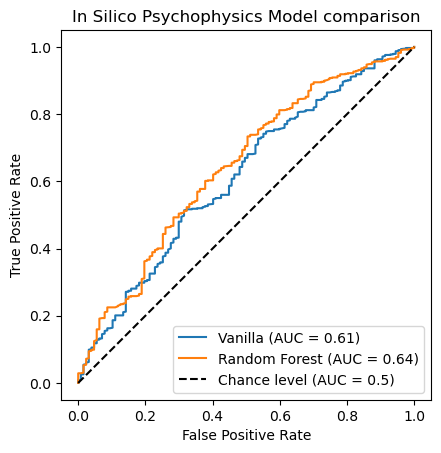

In [349]:
pool_fun = np.max
log0 = 1 * pool_fun(X[:, :9, 9], 1) + 1 * pool_fun(X[:, 10:19, 19], 1)
log1 = 1 * pool_fun(X[:, :9, 19], 1) + 1 * pool_fun(X[:, 10:19, 9], 1)
log_diff = log0 - log1

RocCurveDisplay.from_predictions(
    y[indices_test],
    log_diff[indices_test],
    name="Vanilla",
)
"""
RocCurveDisplay.from_predictions(
    y[indices_test],
    LR_clf.predict_proba(X_test)[:, 1],
    name="Linear Regression",
    ax=plt.gca(),
)
"""

RocCurveDisplay.from_predictions(
    y[indices_test],
    RF_clf.predict_proba(X_test)[:, 1],
    name="Random Forest",
    ax=plt.gca(),
    plot_chance_level=True,
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("In Silico Psychophysics Model comparison")
plt.legend()
plt.show()

Confidence 1 n 241
(168, 950) (168,) (73, 950) (73,)


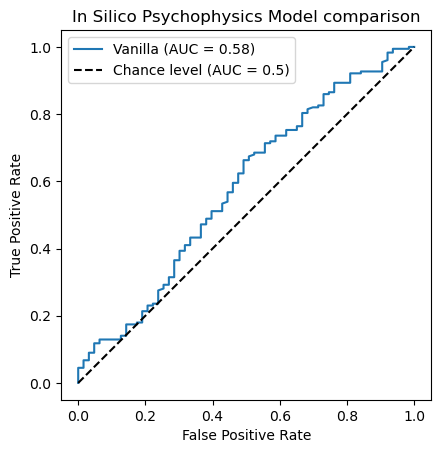

Confidence 2 n 687
(480, 950) (480,) (207, 950) (207,)


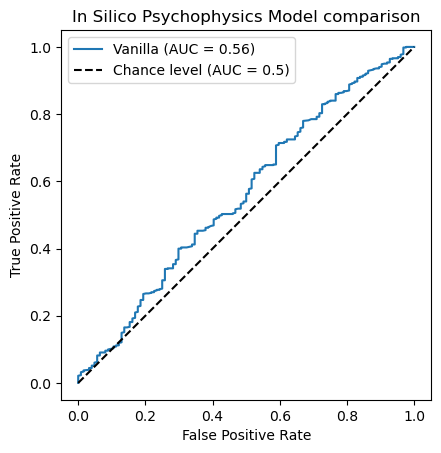

Confidence 3 n 1583
(1108, 950) (1108,) (475, 950) (475,)


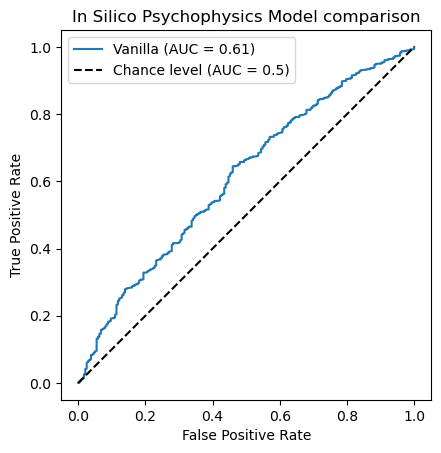

In [361]:
for c in [1, 2, 3]:
    ind = np.array(results['confidences']) == c
    print('Confidence', c, 'n', ind.sum())

    y = np.array(results['correct_trial']).copy().flatten()[ind]
    X = np.array(results['logits_all']).copy()[ind]
    triu_indices = np.triu_indices(20, 1)
    X = X[:, triu_indices[0], triu_indices[1], :]
    X = X.reshape(y.shape[0], -1)
    #X = np.concatenate([X, np.array(results['confidences'])[ind, None], depth[ind, None]], 1)

    indices = np.arange(X.shape[0])
    X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(
        X, y, indices, test_size=0.3, random_state=42, stratify=y)
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

    RF_clf = RandomForestClassifier(
        random_state=0,
        n_estimators=10,
        class_weight='balanced',
        max_depth=4
    ).fit(X_train, y_train)

    y = np.array(results['correct_trial']).copy().flatten()[ind]
    X = np.array(results['logits_all']).copy()[ind]
    X = X.mean(-1)
    pool_fun = np.max
    log0 = 1 * pool_fun(X[:, :9, 9], 1) + 1 * pool_fun(X[:, 10:19, 19], 1)
    log1 = 1 * pool_fun(X[:, :9, 19], 1) + 1 * pool_fun(X[:, 10:19, 9], 1)
    log_diff = log0 - log1

    RocCurveDisplay.from_predictions(
        y,#[indices_test],
        log_diff,#[indices_test],
        name="Vanilla",
        plot_chance_level=True,
    )
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("In Silico Psychophysics Model comparison")
    plt.legend()
    plt.show()

Layer 1 n 375
(262, 950) (262,) (113, 950) (113,)


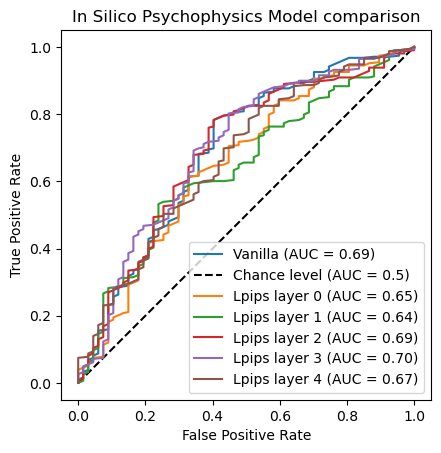

Layer 2 n 476
(333, 950) (333,) (143, 950) (143,)


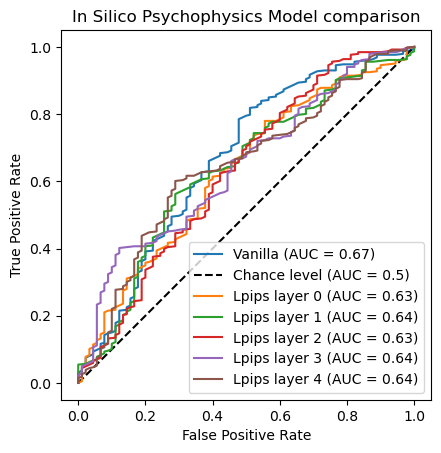

Layer 3 n 1096
(767, 950) (767,) (329, 950) (329,)


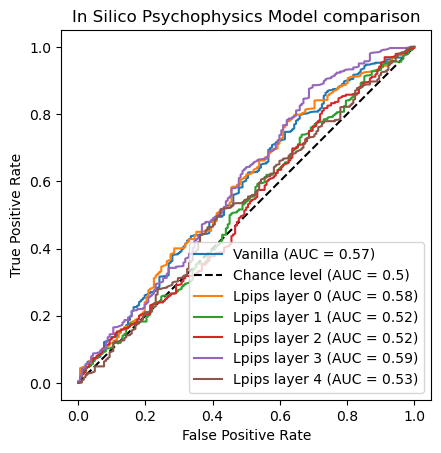

Layer 4 n 564
(394, 950) (394,) (170, 950) (170,)


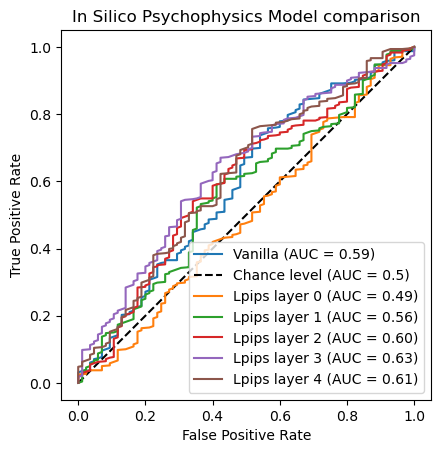

In [366]:
for l in [1, 2, 3, 4]:
    ind = np.array([_.startswith('layer%s' % l) for _ in results['layers']])
    print('Layer', l, 'n', ind.sum())

    y = np.array(results['correct_trial']).copy().flatten()[ind]
    X = np.array(results['logits_all']).copy()[ind]
    triu_indices = np.triu_indices(20, 1)
    X = X[:, triu_indices[0], triu_indices[1], :]
    X = X.reshape(y.shape[0], -1)
    #X = np.concatenate([X, np.array(results['confidences'])[ind, None], depth[ind, None]], 1)

    indices = np.arange(X.shape[0])
    X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(
        X, y, indices, test_size=0.3, random_state=42, stratify=y)
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

    RF_clf = RandomForestClassifier(
        random_state=0,
        n_estimators=10,
        class_weight='balanced',
        max_depth=4
    ).fit(X_train, y_train)

    y = np.array(results['correct_trial']).copy().flatten()[ind]
    X = np.array(results['logits_all']).copy()[ind]
    X = X.mean(-1)
    pool_fun = np.max
    log0 = 1 * pool_fun(X[:, :9, 9], 1) + 1 * pool_fun(X[:, 10:19, 19], 1)
    log1 = 1 * pool_fun(X[:, :9, 19], 1) + 1 * pool_fun(X[:, 10:19, 9], 1)
    log_diff = log0 - log1

    RocCurveDisplay.from_predictions(
        y,#[indices_test],
        log_diff,#[indices_test],
        name="Vanilla",
        plot_chance_level=True,
    )

    for j in range(5):
        y = np.array(results['correct_trial']).copy().flatten()[ind]
        X = np.array(results['logits_all']).copy()[ind]
        X = X[..., j]
        pool_fun = np.max
        log0 = 1 * pool_fun(X[:, :9, 9], 1) + 1 * pool_fun(X[:, 10:19, 19], 1)
        log1 = 1 * pool_fun(X[:, :9, 19], 1) + 1 * pool_fun(X[:, 10:19, 9], 1)
        log_diff = log0 - log1

        RocCurveDisplay.from_predictions(
            y,#[indices_test],
            log_diff,#[indices_test],
            name="Lpips layer %s" % j,
            ax=plt.gca()
        )

    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("In Silico Psychophysics Model comparison")
    plt.legend()
    plt.show()

In [9]:
model = 'resnet50'

with open('results_%s.pickle' % model, 'rb') as handle:
    results = pickle.load(handle)
results.keys(), np.array(results['logits_all']).shape

(dict_keys(['correct_trial', 'layers', 'confidences', 'logits_all', 'task_ids']),
 (7551, 20, 20, 5))

In [14]:
np.unique(results['task_ids'])

array(['resnet50_hard95_optimized-1', 'resnet50_hard95_optimized-10',
       'resnet50_hard95_optimized-11', 'resnet50_hard95_optimized-12',
       'resnet50_hard95_optimized-13', 'resnet50_hard95_optimized-14',
       'resnet50_hard95_optimized-15', 'resnet50_hard95_optimized-16',
       'resnet50_hard95_optimized-17', 'resnet50_hard95_optimized-18',
       'resnet50_hard95_optimized-19', 'resnet50_hard95_optimized-2',
       'resnet50_hard95_optimized-20', 'resnet50_hard95_optimized-21',
       'resnet50_hard95_optimized-22', 'resnet50_hard95_optimized-23',
       'resnet50_hard95_optimized-24', 'resnet50_hard95_optimized-25',
       'resnet50_hard95_optimized-26', 'resnet50_hard95_optimized-27',
       'resnet50_hard95_optimized-28', 'resnet50_hard95_optimized-29',
       'resnet50_hard95_optimized-3', 'resnet50_hard95_optimized-30',
       'resnet50_hard95_optimized-31', 'resnet50_hard95_optimized-32',
       'resnet50_hard95_optimized-33', 'resnet50_hard95_optimized-34',
       'r

Confidence 1 n 241
Confidence 2 n 688
Confidence 3 n 1591


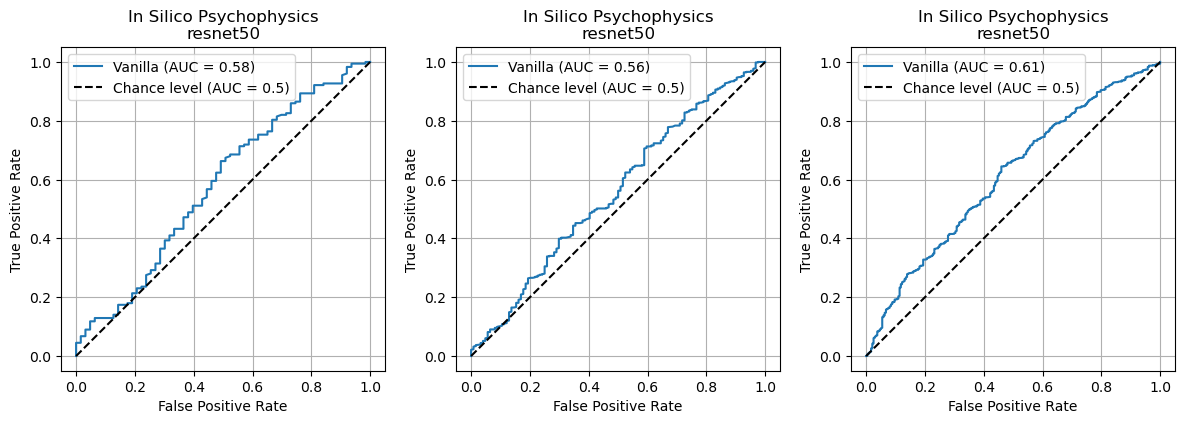

Layer 1 n 240
Layer 2 n 279
Layer 3 n 684
Layer 4 n 388


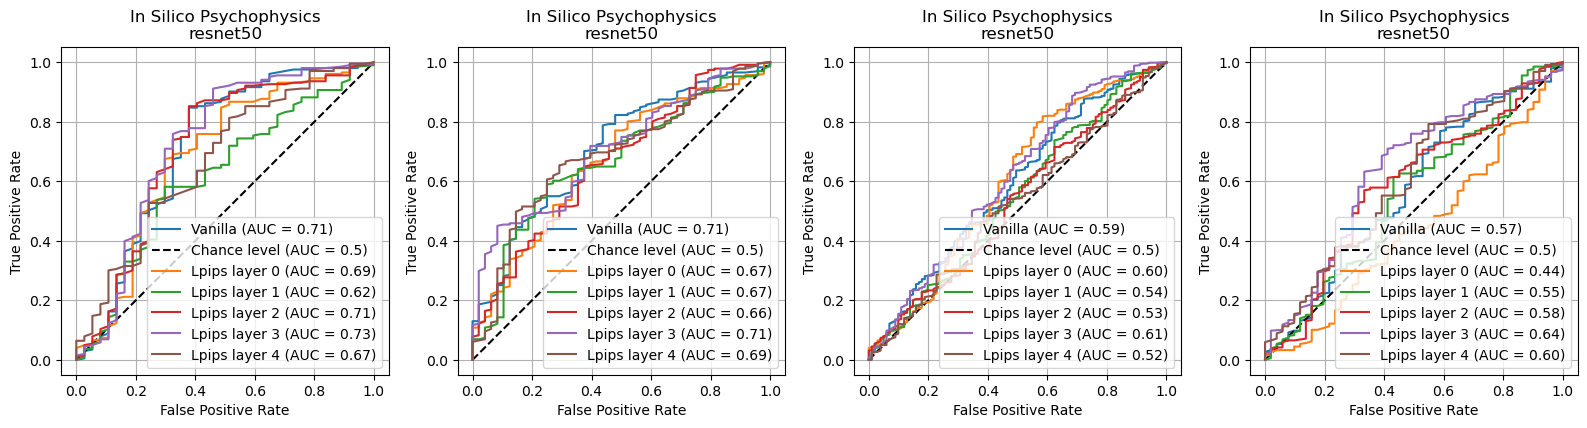

In [17]:
plt.figure(figsize=(12, 4))
for c in [1, 2, 3]:
    plt.subplot(1, 3, c)
    ind = np.logical_and(
        np.array(results['confidences']) == c, 
        np.array(['natural' in _ for _ in results['task_ids']])
    )
    print('Confidence', c, 'n', ind.sum())

    y = np.array(results['correct_trial']).copy().flatten()[ind]
    X = np.array(results['logits_all']).copy()[ind]
    X = X.mean(-1)
    pool_fun = np.max
    log0 = 1 * pool_fun(X[:, :9, 9], 1) + 1 * pool_fun(X[:, 10:19, 19], 1)
    log1 = 1 * pool_fun(X[:, :9, 19], 1) + 1 * pool_fun(X[:, 10:19, 9], 1)
    log_diff = log0 - log1

    RocCurveDisplay.from_predictions(
        y,#[indices_test],
        log_diff,#[indices_test],
        name="Vanilla",
        plot_chance_level=True,
        ax=plt.gca()
    )
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("In Silico Psychophysics\n%s" % model)
    plt.legend()
    plt.grid()
plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 4))
for l in [1, 2, 3, 4]:
    plt.subplot(1, 4, l)
    ind = np.logical_and(
        np.array(results['confidences']) == c, 
        np.array(['natural' in _ for _ in results['task_ids']])
    )
    ind = np.logical_and(
        ind,
        np.array([_.startswith('layer%s' % l) for _ in results['layers']])
    )
    print('Layer', l, 'n', ind.sum())

    y = np.array(results['correct_trial']).copy().flatten()[ind]
    X = np.array(results['logits_all']).copy()[ind]
    X = X.mean(-1)
    pool_fun = np.max
    log0 = 1 * pool_fun(X[:, :9, 9], 1) + 1 * pool_fun(X[:, 10:19, 19], 1)
    log1 = 1 * pool_fun(X[:, :9, 19], 1) + 1 * pool_fun(X[:, 10:19, 9], 1)
    log_diff = log0 - log1

    RocCurveDisplay.from_predictions(
        y,#[indices_test],
        log_diff,#[indices_test],
        name="Vanilla",
        plot_chance_level=True,
        ax=plt.gca()
    )

    for j in range(5):
        y = np.array(results['correct_trial']).copy().flatten()[ind]
        X = np.array(results['logits_all']).copy()[ind]
        X = X[..., j]
        pool_fun = np.max
        log0 = 1 * pool_fun(X[:, :9, 9], 1) + 1 * pool_fun(X[:, 10:19, 19], 1)
        log1 = 1 * pool_fun(X[:, :9, 19], 1) + 1 * pool_fun(X[:, 10:19, 9], 1)
        log_diff = log0 - log1

        RocCurveDisplay.from_predictions(
            y,#[indices_test],
            log_diff,#[indices_test],
            name="Lpips layer %s" % j,
            ax=plt.gca()
        )

    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("In Silico Psychophysics\n%s" % model)
    plt.legend()
    plt.grid()
plt.tight_layout()
plt.show()

In [18]:
model = 'googlenet'

with open('results_%s.pickle' % model, 'rb') as handle:
    results = pickle.load(handle)
results.keys(), np.array(results['logits_all']).shape

(dict_keys(['correct_trial', 'layers', 'confidences', 'logits_all', 'task_ids']),
 (5031, 20, 20, 5))

In [21]:
np.unique([_.split('-')[0] for _ in results['task_ids']])

array(['googlenet_natural', 'googlenet_optimized'], dtype='<U19')

In [27]:
layers = np.unique([_.split('_')[0][:-1] for _ in results['layers']])
layers

array(['mixed3', 'mixed4', 'mixed5'], dtype='<U6')

Confidence 1 n 59
Confidence 2 n 438
Confidence 3 n 2023


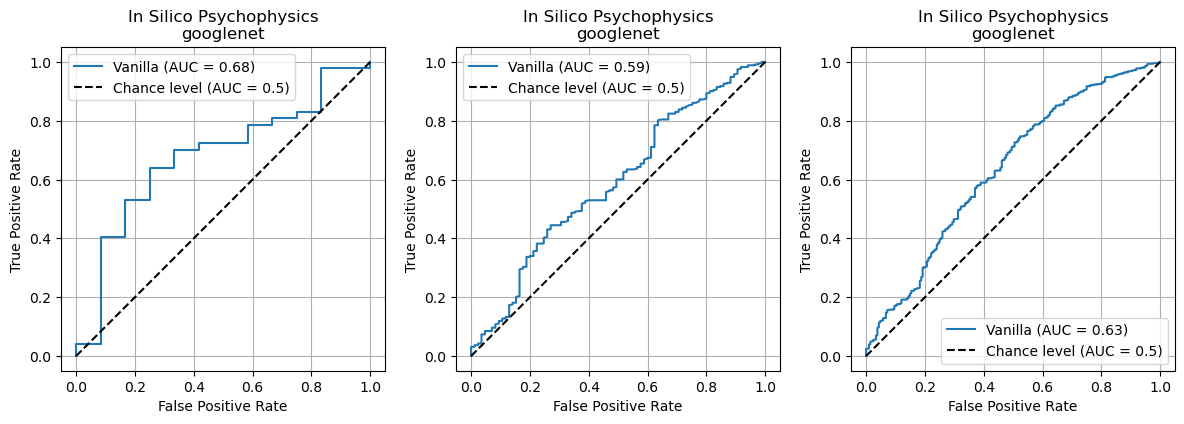

Layer 1 n 428
Layer 2 n 1141
Layer 3 n 454


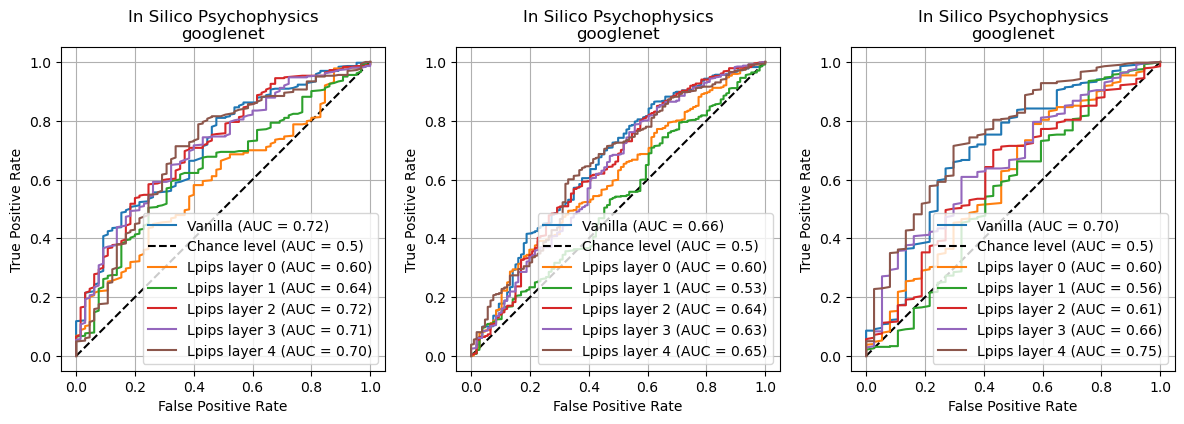

In [28]:
plt.figure(figsize=(12, 4))
for c in [1, 2, 3]:
    plt.subplot(1, 3, c)
    ind = np.logical_and(
        np.array(results['confidences']) == c, 
        np.array(['natural' in _ for _ in results['task_ids']])
    )
    print('Confidence', c, 'n', ind.sum())

    y = np.array(results['correct_trial']).copy().flatten()[ind]
    X = np.array(results['logits_all']).copy()[ind]
    X = X.mean(-1)
    pool_fun = np.max
    log0 = 1 * pool_fun(X[:, :9, 9], 1) + 1 * pool_fun(X[:, 10:19, 19], 1)
    log1 = 1 * pool_fun(X[:, :9, 19], 1) + 1 * pool_fun(X[:, 10:19, 9], 1)
    log_diff = log0 - log1

    RocCurveDisplay.from_predictions(
        y,#[indices_test],
        log_diff,#[indices_test],
        name="Vanilla",
        plot_chance_level=True,
        ax=plt.gca()
    )
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("In Silico Psychophysics\n%s" % model)
    plt.legend()
    plt.grid()
plt.tight_layout()
plt.show()

plt.figure(figsize=(4 * len(layers), 4))
for l in range(1, len(layers) + 1):
    plt.subplot(1, len(layers), l)
    ind = np.logical_and(
        np.array(results['confidences']) == c, 
        np.array(['natural' in _ for _ in results['task_ids']])
    )
    ind = np.logical_and(
        ind,
        np.array([layers[l - 1] in _ for _ in results['layers']])
    )
    print('Layer', l, 'n', ind.sum())

    y = np.array(results['correct_trial']).copy().flatten()[ind]
    X = np.array(results['logits_all']).copy()[ind]
    X = X.mean(-1)
    pool_fun = np.max
    log0 = 1 * pool_fun(X[:, :9, 9], 1) + 1 * pool_fun(X[:, 10:19, 19], 1)
    log1 = 1 * pool_fun(X[:, :9, 19], 1) + 1 * pool_fun(X[:, 10:19, 9], 1)
    log_diff = log0 - log1

    RocCurveDisplay.from_predictions(
        y,#[indices_test],
        log_diff,#[indices_test],
        name="Vanilla",
        plot_chance_level=True,
        ax=plt.gca()
    )

    for j in range(5):
        y = np.array(results['correct_trial']).copy().flatten()[ind]
        X = np.array(results['logits_all']).copy()[ind]
        X = X[..., j]
        pool_fun = np.max
        log0 = 1 * pool_fun(X[:, :9, 9], 1) + 1 * pool_fun(X[:, 10:19, 19], 1)
        log1 = 1 * pool_fun(X[:, :9, 19], 1) + 1 * pool_fun(X[:, 10:19, 9], 1)
        log_diff = log0 - log1

        RocCurveDisplay.from_predictions(
            y,#[indices_test],
            log_diff,#[indices_test],
            name="Lpips layer %s" % j,
            ax=plt.gca()
        )

    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("In Silico Psychophysics\n%s" % model)
    plt.legend()
    plt.grid()
plt.tight_layout()
plt.show()

In [32]:
model = 'clip-resnet50_hard95'

with open('results_%s.pickle' % model, 'rb') as handle:
    results = pickle.load(handle)
results.keys(), np.array(results['logits_all']).shape

(dict_keys(['correct_trial', 'layers', 'confidences', 'logits_all', 'task_ids']),
 (11, 20, 20, 5))

In [30]:
np.unique([_ for _ in results['task_ids']])#.split('-')[0]

array(['resnet50_hard85_natural-1'], dtype='<U25')